# Практика 7: Создание и использование генеративных противоречивых примеров (GAN-based Adversarial Examples)

##  Цель задания:
 Изучить использование генеративных моделей (GAN — Generative Adversarial Networks) для создания противоречивых примеров. В этом задании мы создадим противоречивые примеры с использованием GAN и проверим их влияние на модели классификации.

 ###  Задачи:
 1. Изучить концепцию генеративных противоречивых примеров.
 2. Реализовать простую GAN для создания противоречивых изображений.
 3. Оценить точность моделей классификации на противоречивых примерах, созданных с
 помощью GAN.
 4. Сравнить атаку на обе модели (полносвязную и свёрточную сети).

 Выполнил студент ББМО-02-23 Евдокимов А.М.

## Шаги выполнения:

###  Шаг 1: Концепция генеративных противоречивых примеров

 Генеративные противоречивые примеры — это изображения, созданны генеративными моделями, которые могут обманывать модели классификации. В отличие от стандартных атак (например, FGSM или PGD), где добавляются малые шумы, GAN могут генерировать реалистичные, но сложные для распознавания модели изображения, которые сложно отличить от настоящих данных.

###  Шаг 2: Создание простой GAN для генерации противоречивых примеров
 Мы создадим генеративную состязательную сеть (GAN), состоящую из двух частей: генератора и дискриминатора. Генератор будет создавать изображения, а дискриминатор — пытаться распознать поддельные изображения.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0

# Добавление одного измерения (для работы CNN)
train_images = np.expand_dims(train_images, axis=-1)

# Генератор
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Дискриминатор
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Создание моделей
generator = build_generator()
discriminator = build_discriminator()

# Компиляция дискриминатора
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Создание GAN
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Функция обучения GAN
def train_gan(generator, discriminator, gan, epochs=1000, batch_size=64):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Обучение дискриминатора
        idx = np.random.randint(0, train_images.shape[0], half_batch)
        real_images = train_images[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Обучение генератора через дискриминатор
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % 100 == 0:
            print(f'{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]')

# Обучение GAN
train_gan(generator, discriminator, gan)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0 [D loss: [0.70903695 0.3671875 ]] [G loss: [array(0.68743455, dtype=float32), array(0.68743455, dtype=float32), array(0.578125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━

### Шаг 3: Генерация противоречивых примеров с помощью GAN
 Теперь мы сгенерируем противоречивые примеры, используя обученный генератор GAN.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


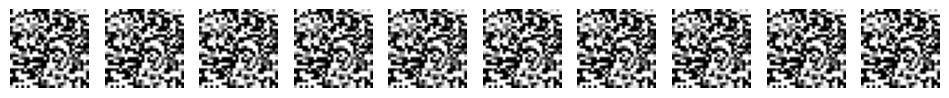

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация противоречивых примеров
def generate_adversarial_examples(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, 100))
    generated_images = generator.predict(noise)
    return generated_images

# Генерация 100 примеров
adversarial_images = generate_adversarial_examples(generator, 100)

# Визуализация противоречивых примеров
plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    # Убедитесь, что изображение имеет размер 16x16 (или соответствующий размер, генерируемый вашей моделью)
    plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')  # Используйте правильный размер
    plt.axis('off')  # Скрыть оси для чистоты
plt.show()

### Шаг 4: Оценка моделей на противоречивых примерах
 Теперь проверим, как обученные модели (полносвязная сеть и CNN) справляются с противоречивыми примерами, созданными с помощью GAN.

In [ ]:
# Загрузка моделей
model1 = tf.keras.models.load_model('mnist_model1.h5')
model2 = tf.keras.models.load_model('mnist_model2.h5')

# Преобразование данных
adv_images_resized = tf.image.resize(adversarial_images, (28, 28))  # Изменяет размер изображений
adv_images_reshaped = adversarial_images.reshape(-1, 28, 28, 1)

# Оценка
loss1, acc1 = model1.evaluate(adv_images_reshaped, np.ones((100, 10)))
loss2, acc2 = model2.evaluate(adv_images_reshaped, np.ones((100, 10)))

print(f'Accuracy of model1 on adversarial GAN examples: {acc1}')
print(f'Accuracy of model2 on adversarial GAN examples: {acc2}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 276.2099  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 1257.7838 
Accuracy of model1 on adversarial GAN examples: 0.0
Accuracy of model2 on adversarial GAN examples: 0.0


## Выводы

Классификаторы показали полную неспособность справляться с противоречивыми примерами, что делает их крайне уязвимыми для атак, создаваемых с помощью GAN. Эти данные оказались достаточно сложными и реалистичными, чтобы сбить модели с толку, что подтверждает высокую эффективность таких методов генерации. Для повышения устойчивости моделей к подобным воздействиям требуется применять стратегии, такие как обучение на сложных примерах, усиление регуляризации или улучшение архитектур. Полученные результаты указывают на необходимость дальнейших исследований в направлении защиты моделей от подобных атак.